In [1]:
import pandas as pd
import sqlite3
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
from zipfile import ZipFile
import io
import numpy as np

# Part 1

In [2]:
def load_dataset(limit=None):
    c = sqlite3.connect("data/images.db")
    query = """
    SELECT file_name, district_name, lon, lat, water_ratio, forest_ratio, agriculture_ratio, developed_ratio FROM
    sample INNER JOIN districts ON sample.district_id == districts.district_id
    """
    if limit != None:
        query += " LIMIT " + str(limit)
    df = pd.read_sql(query, c)
    c.close()
    return df
df = load_dataset(400)
train, test = train_test_split(df, random_state=0)

In [3]:
#q1
test.iloc[-5:]

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
146,area0146.npy,district 08,-87.869312,44.365150,0.0048,0.0249,0.8343,0.0896
135,area0135.npy,district 06,-87.852985,43.935362,0.0030,0.0463,0.8241,0.0697
390,area0390.npy,district 01,-88.908064,42.562049,0.0000,0.1818,0.6871,0.0763
264,area0264.npy,district 01,-87.842951,42.704875,0.0030,0.0376,0.0423,0.8906
364,area0364.npy,district 01,-87.987364,42.754155,0.0025,0.0498,0.8408,0.0689


<AxesSubplot:xlabel='lat', ylabel='developed_ratio'>

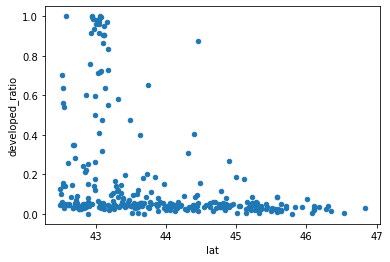

In [4]:
#q2
train.plot.scatter(x="lat", y="developed_ratio")

In [5]:
#q3
xcols = lr_xcols = ["lat", "lon", "water_ratio", "forest_ratio", "agriculture_ratio"]
ycol = "developed_ratio"
lr = LinearRegression()
lr.fit(train[xcols], train[ycol])
test_copy = test.copy()
test_copy["predicted"] = lr.predict(test[xcols])
test_copy.head(5)

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio,predicted
132,area0132.npy,district 06,-87.940213,43.750300,0.0058,0.0266,0.5506,0.2990,0.187514
309,area0309.npy,district 07,-91.854009,45.352143,0.0002,0.1366,0.8074,0.0401,-0.155128
341,area0341.npy,district 01,-88.294035,42.656175,0.0010,0.3283,0.2029,0.1805,0.376093
196,area0196.npy,district 06,-89.557249,44.187877,0.0000,0.0836,0.8079,0.0412,-0.054414
246,area0246.npy,district 05,-88.596203,43.159942,0.0002,0.0201,0.6677,0.0921,0.188176


In [6]:
#q4
lr.score(test[xcols], test[ycol])

0.7138077753811825

Text(0, 0.5, 'predicted developed_ratio')

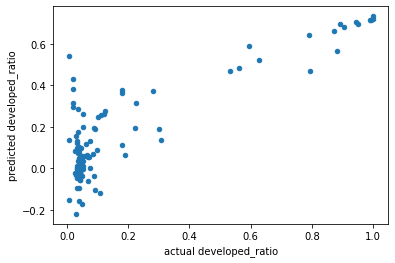

In [7]:
#q5
ax = test_copy.plot.scatter(x="developed_ratio", y="predicted")
ax.set_xlabel("actual developed_ratio")
ax.set_ylabel("predicted developed_ratio")

Text(0, 0.5, 'Coefficient')

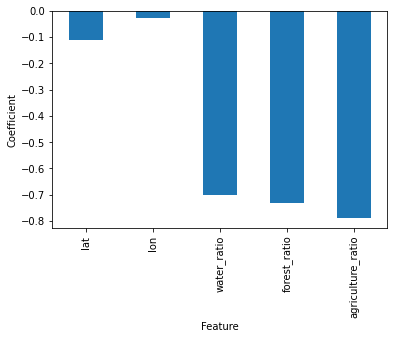

In [8]:
#q6
ax = pd.Series(lr.coef_, index=xcols).plot.bar()
ax.set_xlabel("Feature")
ax.set_ylabel("Coefficient")

In [9]:
trans = make_column_transformer(
    (OneHotEncoder(), ["district_name"]),
    (PolynomialFeatures(degree=2), ["water_ratio", "forest_ratio", "agriculture_ratio"]),
    remainder="passthrough"
)

oh_lr = Pipeline([
    ("trans", trans),
    ("lr", LinearRegression()),
])
xcols = ["district_name", "lat", "lon", "water_ratio", "forest_ratio", "agriculture_ratio"]
oh_lr.fit(train[xcols], train[ycol])
test_copy = test.copy()
test_copy["predicted"] = oh_lr.predict(test[xcols])
test_copy.head(5)

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio,predicted
132,area0132.npy,district 06,-87.940213,43.750300,0.0058,0.0266,0.5506,0.2990,0.144766
309,area0309.npy,district 07,-91.854009,45.352143,0.0002,0.1366,0.8074,0.0401,-0.050386
341,area0341.npy,district 01,-88.294035,42.656175,0.0010,0.3283,0.2029,0.1805,0.215990
196,area0196.npy,district 06,-89.557249,44.187877,0.0000,0.0836,0.8079,0.0412,-0.001009
246,area0246.npy,district 05,-88.596203,43.159942,0.0002,0.0201,0.6677,0.0921,0.170984


In [10]:
#q7
oh_lr.score(test[xcols], test[ycol])

0.8420970788505492

# Part 2

In [11]:
#q8
lr_scores = cross_val_score(lr, train[lr_xcols], train[ycol], cv=8)
oh_lr_scores = cross_val_score(oh_lr, train[xcols], train[ycol], cv=8)
lr_scores.mean(), oh_lr_scores.mean()

(0.6517545836308132, 0.7882683505969759)

In [12]:
#q9
lr_scores.std(), oh_lr_scores.std()

(0.11307460959365209, 0.06667525211477908)

# Part 3

In [13]:
df = load_dataset()
zf = ZipFile(f"data/images.zip")

def load_map(file_name):
    with zf.open(file_name) as f:
        buf = io.BytesIO(f.read())
        return np.load(buf)

In [14]:
for i in df.index:
    file_name = df.at[i, "file_name"]
    m = load_map(file_name)
    df.at[i, "water_ratio"] = (m == 11).mean()
    df.at[i, "forest_ratio"] = ((m >= 41) & (m <= 43)).mean()
    df.at[i, "agriculture_ratio"] = ((m >= 81) & (m <= 82)).mean()
    df.at[i, "developed_ratio"] = ((m >= 21) & (m <= 24)).mean()


In [15]:
m = load_map("area0320.npy")
m.shape

(100, 100)

In [16]:
#q10
m = load_map("area1234.npy")
(m == 52).sum()

80

In [17]:
#q11
train, test = train_test_split(df, random_state=0)
test.iloc[-5:]

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
936,area0936.npy,district 03,-92.152574,44.502114,0.0000,0.4248,0.5276,0.0396
1524,area1524.npy,district 02,-90.151901,43.211515,0.0002,0.1870,0.7766,0.0344
1415,area1415.npy,district 05,-88.921017,43.197963,0.0001,0.0543,0.6463,0.0305
1223,area1223.npy,district 04,-87.906383,43.074510,0.0145,0.0169,0.0060,0.9189
1548,area1548.npy,district 03,-90.359220,43.570773,0.0000,0.2854,0.6702,0.0395


In [18]:
#q12
lr_scores = cross_val_score(lr, train[lr_xcols], train[ycol], cv=8)
oh_lr_scores = cross_val_score(oh_lr, train[xcols], train[ycol], cv=8)
lr_scores.mean(), oh_lr_scores.mean()

(0.7729881088121584, 0.8844524099928219)

# Part 4

Text(0.5, 1.0, 'Madison 2016')

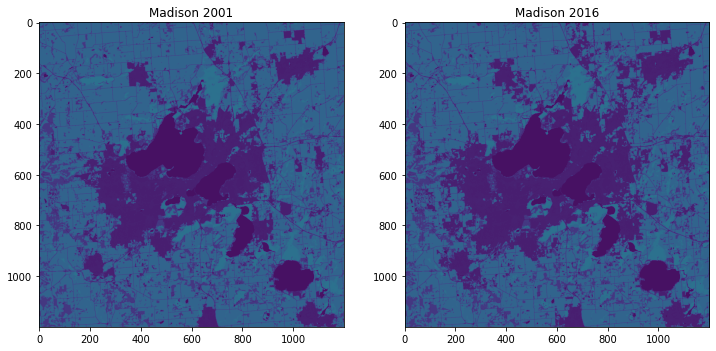

In [19]:
from matplotlib import pyplot as plt

with ZipFile("data/madison.zip") as zf:
    with zf.open("year-2001.npy") as f:
        buf = io.BytesIO(f.read())
        mad2001 = np.load(buf)
    with zf.open("year-2016.npy") as f:
        buf = io.BytesIO(f.read())
        mad2016 = np.load(buf)

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].imshow(mad2001, vmin=0, vmax=255)
axes[0].set_title("Madison 2001")
axes[1].imshow(mad2016, vmin=0, vmax=255)
axes[1].set_title("Madison 2016")

Text(0.5, 1.0, 'Madison 2016')

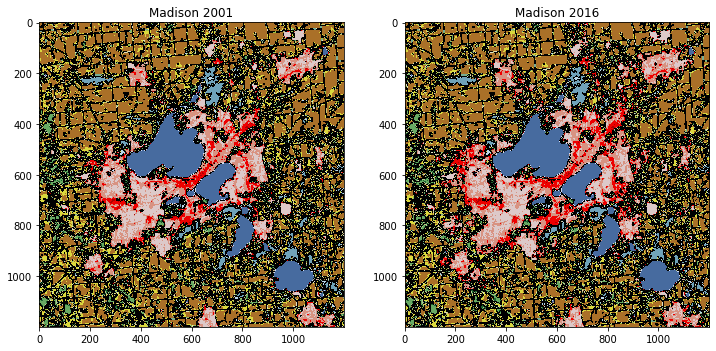

In [20]:
from matplotlib.colors import ListedColormap

def get_usage_colormap():
    use_cmap = np.zeros(shape=(256,4))
    use_cmap[:,-1] = 1
    uses = np.array([
        [0, 0.00000000000, 0.00000000000, 0.00000000000],
        [11, 0.27843137255, 0.41960784314, 0.62745098039],
        [12, 0.81960784314, 0.86666666667, 0.97647058824],
        [21, 0.86666666667, 0.78823529412, 0.78823529412],
        [22, 0.84705882353, 0.57647058824, 0.50980392157],
        [23, 0.92941176471, 0.00000000000, 0.00000000000],
        [24, 0.66666666667, 0.00000000000, 0.00000000000],
        [31, 0.69803921569, 0.67843137255, 0.63921568628],
        [41, 0.40784313726, 0.66666666667, 0.38823529412],
        [42, 0.10980392157, 0.38823529412, 0.18823529412],
        [43, 0.70980392157, 0.78823529412, 0.55686274510],
        [51, 0.64705882353, 0.54901960784, 0.18823529412],
        [52, 0.80000000000, 0.72941176471, 0.48627450980],
        [71, 0.88627450980, 0.88627450980, 0.75686274510],
        [72, 0.78823529412, 0.78823529412, 0.46666666667],
        [73, 0.60000000000, 0.75686274510, 0.27843137255],
        [74, 0.46666666667, 0.67843137255, 0.57647058824],
        [81, 0.85882352941, 0.84705882353, 0.23921568628],
        [82, 0.66666666667, 0.43921568628, 0.15686274510],
        [90, 0.72941176471, 0.84705882353, 0.91764705882],
        [95, 0.43921568628, 0.63921568628, 0.72941176471],
    ])
    for row in uses:
        use_cmap[int(row[0]),:-1] = row[1:]
    return ListedColormap(use_cmap)

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].imshow(mad2001, vmin=0, vmax=255, cmap=get_usage_colormap())
axes[0].set_title("Madison 2001")
axes[1].imshow(mad2016, vmin=0, vmax=255, cmap=get_usage_colormap())
axes[1].set_title("Madison 2016")

In [21]:
#q13
mad2001.shape

(1200, 1200)

In [22]:
#q14
(mad2016 != mad2001).mean()

0.06156458333333333

In [23]:
#q15
with ZipFile("data/madison.zip") as zf:
    years = [int(info.filename[5:9]) for info in zf.infolist()]
years

[2001, 2004, 2006, 2008, 2011, 2013, 2016]

In [24]:
#q16
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8,8))
def frame(fnum):
    year = years[fnum]
    with ZipFile("data/madison.zip") as zf:
        with zf.open(f"year-{year}.npy") as f:
            buf = io.BytesIO(f.read())
            mad = np.load(buf)
            ax.set_title(f"Madison {year}")
            ax.imshow(mad, vmin=0, vmax=255, cmap=get_usage_colormap())

a = FuncAnimation(fig, frame, frames=len(years), interval=1000)
html = a.to_html5_video()
plt.close(fig)
HTML(html)